In [1]:
import os
import sys
import subprocess
import shutil
import pandas as pd
import numpy as np
import pysam

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
threads = 16
expect_cells = 8500
barcode_whitelist = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/10xBarcoded_SingleCell/3M-february-2018.txt"
blaze_path = "~/.local/bin/blaze"
root_dir = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/adaptive_sampling/experiment_data/"
outpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/adaptive_sampling/demultiplexing_results/"

for experiment in os.listdir(root_dir):
    print(f"Working: {experiment}...")
    input_path = f"{root_dir}{experiment}/fastq_pass/"
    out_prefix = f"{outpath}/{experiment}_"

    # Build the command list
    command = [
        blaze_path,
        f"--expect-cells {expect_cells}",
        f"--threads {threads}",
        f"--full-bc-whitelist {barcode_whitelist}",
        f"--output-prefix {out_prefix}",
        input_path,
    ]

    # Execute the command using subprocess.run
    output = subprocess.run(" ".join(command), shell=True, capture_output=True)

Working: fifth_AS_test_03142024...
Working: first_AS_test_03122024...
Working: sixth_AS_test_03142024...
Working: second_AS_test_03132024...
Working: seventh_AS_03152024...
Working: second_iHSC_AS_04162024...
Working: fourth_AS_test_03142024...
Working: third_AS_test_03142024...
Working: first_iHSC_AS_04152024...
Working: 2024-04-22-iHSC-4th-run...
Working: 2024-04-18-iHSC-3rd-run...


# Analyze

In [3]:
sample = 100000
df = []
for test_run in os.listdir(outpath):
    if not test_run.endswith("_putative_bc.csv"):
        continue

    fpath = f"{outpath}{test_run}"
    tmp = pd.read_csv(fpath, nrows=sample)
    tmp['run'] = test_run
    df.append(tmp)

df = pd.concat(df)
df['direction'] = np.sign(df['umi_end'])
df['direction'] = df['direction'].fillna('0')
print(f"{df.shape=}")
df.head()

df.shape=(1100000, 9)


,read_id,putative_bc,putative_bc_min_q,putative_umi,umi_end,pre_bc_flanking,post_umi_flanking,run,direction
0,3969df98-889d-485f-9a9a-890252b5d704,NaN,NaN,NaN,NaN,NaN,NaN,third_AS_test_03142024_putative_bc.csv,0
1,6872bb41-6952-41da-95ce-beab6596f289,NaN,NaN,NaN,NaN,NaN,NaN,third_AS_test_03142024_putative_bc.csv,0
2,8965025d-cdf9-4708-8a40-ec6650980eda,NaN,NaN,NaN,NaN,NaN,NaN,third_AS_test_03142024_putative_bc.csv,0
3,88617e22-13ee-437f-978d-8965ccfb1a2e,TGTGCGGTCGACATTG,5.0,TAGTGGACAGCT,-62.0,CATCT,TTTTT,third_AS_test_03142024_putative_bc.csv,-1.0
4,c0b86fa1-336b-4d7c-b622-6ba70c686665,GATTCTTCAGGACTTG,5.0,ATTTTTCGGCGT,-89.0,GATCT,TTTTT,third_AS_test_03142024_putative_bc.csv,-1.0


In [4]:
t = df[['run', 'direction']].value_counts(normalize=False)
t = pd.DataFrame(t)
t = t.reset_index()
t = t.sort_values(by=['run', 'direction'])
t = pd.pivot_table(t, index='run', columns='direction', values='count')
t = t / sample
t

direction,-1.0,1.0,0
run,,,
2024-04-18-iHSC-3rd-run_putative_bc.csv,0.18507,0.43670,0.37823
2024-04-22-iHSC-4th-run_putative_bc.csv,0.20479,0.46858,0.32663
fifth_AS_test_03142024_putative_bc.csv,0.44412,0.02574,0.53014
first_AS_test_03122024_putative_bc.csv,0.54291,0.02119,0.43590
first_iHSC_AS_04152024_putative_bc.csv,0.39183,0.48262,0.12555
fourth_AS_test_03142024_putative_bc.csv,0.45795,0.02621,0.51584
second_AS_test_03132024_putative_bc.csv,0.43699,0.02666,0.53635
second_iHSC_AS_04162024_putative_bc.csv,0.34477,0.43212,0.22311
seventh_AS_03152024_putative_bc.csv,0.47382,0.03029,0.49589


,run,variable,value
0,2024-04-18-iHSC-3rd-run,Backward,0.18507
22,2024-04-18-iHSC-3rd-run,Undetectable,0.37823
11,2024-04-18-iHSC-3rd-run,Forward,0.43670
1,2024-04-22-iHSC-4th-run,Backward,0.20479
23,2024-04-22-iHSC-4th-run,Undetectable,0.32663


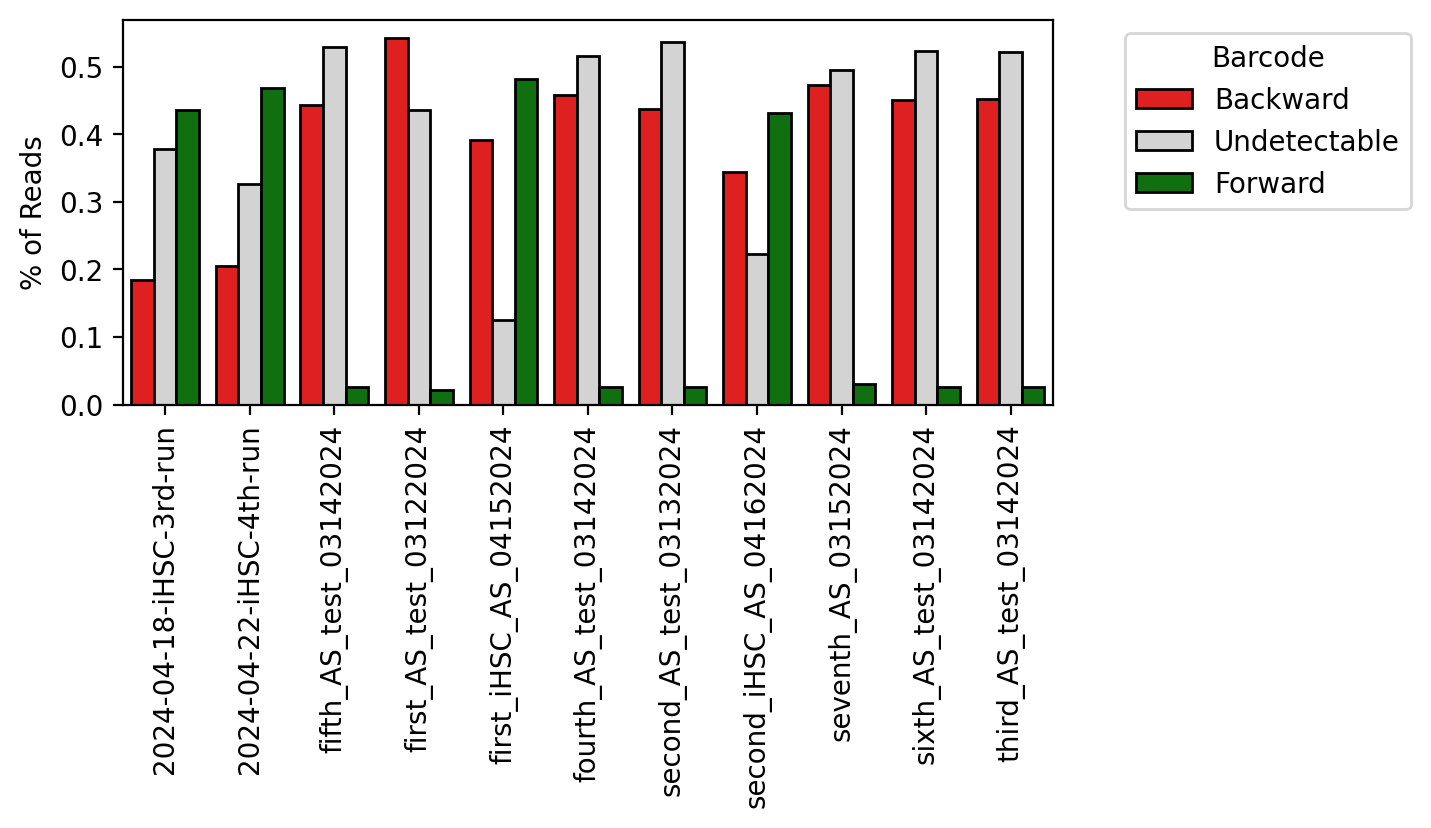

In [5]:
pdf = t.copy()
pdf.columns = ['Backward', 'Forward', 'Undetectable']
pdf = pdf.reset_index()
pdf = pd.melt(pdf, id_vars='run')
pdf['run'] = pdf['run'].apply(lambda x: x.replace("_putative_bc.csv", ""))
pdf = pdf.sort_values(by='run')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 2.5
sns.barplot(data=pdf, 
            x='run',
            y='value',
            hue='variable',
            palette=['r', 'lightgrey', 'green'],
            ec='k')

plt.ylabel("% of Reads")
plt.xlabel("")
plt.gca().tick_params(axis='x', rotation=90)
sns.move_legend(plt.gca(),
                loc='upper right',
                title='Barcode',
                bbox_to_anchor=(1.4, 1),
                )

pdf.head()

In [6]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Check the detected barcodes

In [7]:
# load the barcodes of interest
fpath = "../2000_closest.fasta"

def load_fasta_barcodes(fpath):
    """A function to read the barcodes from a fasta
    file """
    barcodes = []
    
    for line in open(fpath):
        if not line.startswith(">"):
            continue
        else:
            barcode = line.replace(">", '').split(":")[0]
            barcodes.append(barcode)
    return barcodes
    
barcodes = load_fasta_barcodes(fpath)
print(len(barcodes))

2000


In [8]:
print(f"{df.shape=}")

pdf = df[df['putative_bc'].isin(barcodes)]
print(f"{pdf.shape=}")

pdf['run'].value_counts()

df.shape=(1100000, 9)
pdf.shape=(46999, 9)


run
first_iHSC_AS_04152024_putative_bc.csv     8259
second_iHSC_AS_04162024_putative_bc.csv    6820
2024-04-22-iHSC-4th-run_putative_bc.csv    5828
seventh_AS_03152024_putative_bc.csv        5221
2024-04-18-iHSC-3rd-run_putative_bc.csv    5017
first_AS_test_03122024_putative_bc.csv     3070
fourth_AS_test_03142024_putative_bc.csv    2653
third_AS_test_03142024_putative_bc.csv     2615
sixth_AS_test_03142024_putative_bc.csv     2560
fifth_AS_test_03142024_putative_bc.csv     2559
second_AS_test_03132024_putative_bc.csv    2397
Name: count, dtype: int64

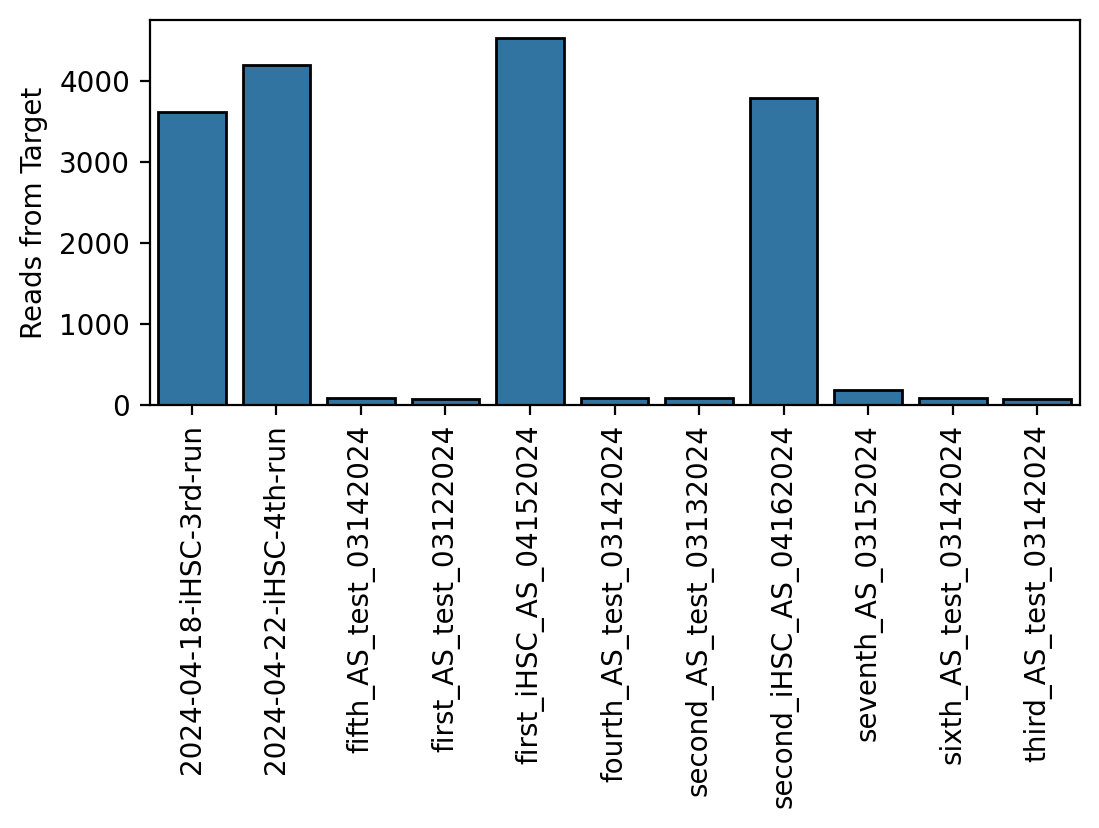

In [9]:
pdf = df.copy()

pdf = pdf[pdf['direction'] == 1.0]

pdf['is_top2000'] = pdf['putative_bc'].isin(barcodes)

gx = pdf.groupby(['run']).agg(
    barcode_of_interest = ('is_top2000', 'sum'),
).reset_index()

gx['run'] = gx['run'].apply(lambda x: x.replace("_putative_bc.csv", ""))
gx = gx.sort_values(by='run')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 2.5
sns.barplot(data=gx, 
            x='run',
            y='barcode_of_interest',
            ec='k')

plt.ylabel("Reads from Target")
plt.xlabel("")
plt.gca().tick_params(axis='x', rotation=90)

In [ ]:
break